In [1159]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import StackingRegressor, BaggingRegressor, GradientBoostingRegressor


import warnings
warnings.filterwarnings('ignore')

In [1160]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1161]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    plt.figure(figsize=(8,8))
    
    plt.scatter(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()

In [1162]:
DATASET_PATH = './train.csv'
DATASET_PATH_TEST = './test.csv'

train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(DATASET_PATH_TEST)

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

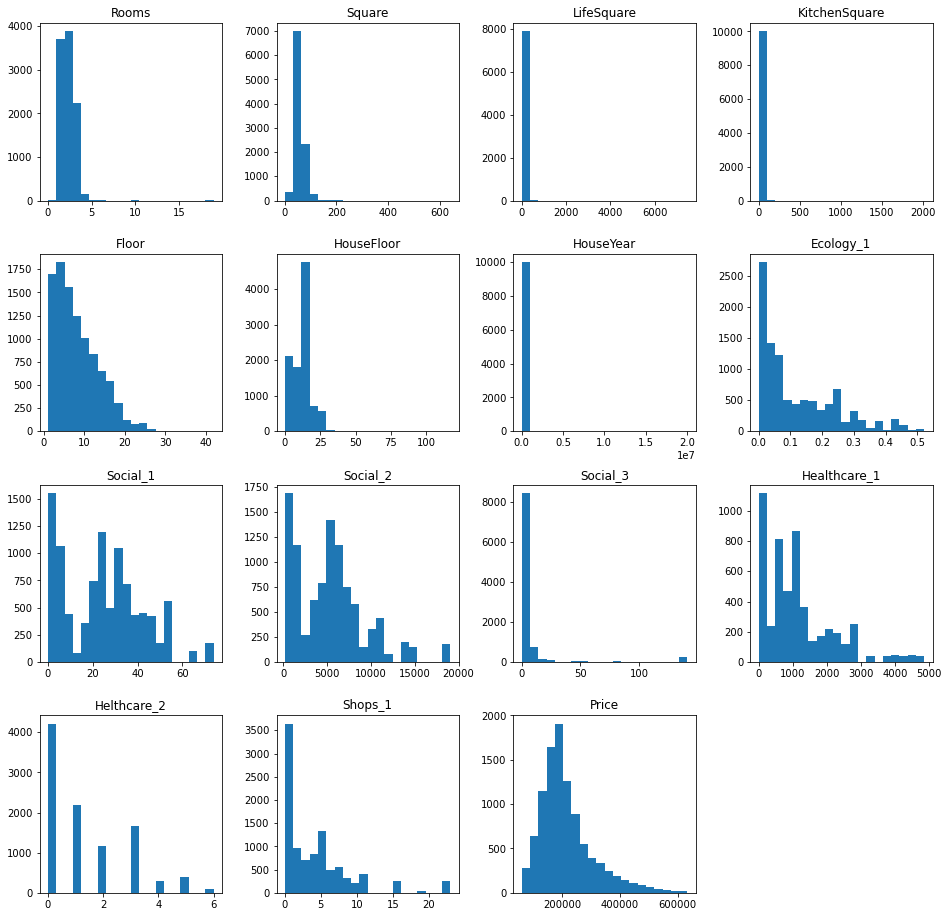

In [1163]:
drop_hist_name = ['Id', 'DistrictId']
train_df_hist = train_df.drop(columns=drop_hist_name)
train_df_hist.hist(figsize=(16,16), bins=20, grid=False)

In [1164]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [1165]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.binary_to_numbers = {'A': 1, 'B': 0}
        self.square_min_value = None
        self.ls_min_value = None  # ls = LifeSquare
        self.kitchen_min_value = None

    def fit(self, X):
        """Сохранение статистик"""
        self.medians = X.median()
        self.square_min_value = np.quantile(X['Square'], q=0.025)
        self.ls_min_value = np.quantile(X['LifeSquare'], q=0.025)
        self.kitchen_min_value = np.quantile(X['KitchenSquare'], q=0.5)

    def transform(self, X):
        """Трансформация данных"""
        #X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        random.seed(42)
        X['Healthcare_1'].fillna(random.randint(50, 1000), inplace=True)#Я так понимаю тут расстояние от квартиры до медицинского учреждения. 
        #Заполнить их медианой или средним значением было бы странно, ведь тогда получилось бы, что везде одинаковое расстояние. Поэтому заполнил случайными значениями.
        X.loc[((X['Healthcare_1'] > 1000) | (X['Healthcare_1'] < 10)), 'Healthcare_1'] = random.randint(50, 1000)
        X.loc[(X['Square'] > 275.645284) | (X['Square'] < self.square_min_value), 'Square'] = self.medians['Square']
        X['LifeSquare'].fillna(X['Square'] * 0.6, inplace=True)
        X.loc[(X['LifeSquare'] >= X['Square']) | (X['LifeSquare'] < self.ls_min_value), 'LifeSquare'] = X['Square'] * 0.6   
        #Так как заполнять жилую площадь медианой некорректно потому что есть шанс, что жилая площадь окажется больше площади квартиры. 
        #То я решил заполнить жилую площадь 60% от общей площади квартиры. 
        #Так как жилой является площадь комнат, предназначенных, согласно проекту, для постоянного проживания, то есть гостиных и спален.
        X.loc[((X['Rooms'] > 6.0) | (X['Rooms'] < 1.0)), 'Rooms'] = self.medians['Rooms']
        X.loc[(X['KitchenSquare'] >= X['LifeSquare']) | (X['KitchenSquare'] < self.kitchen_min_value), 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[((X['HouseFloor'] > 95) | (X['HouseFloor'] == 0)), 'HouseFloor'] = self.medians['HouseFloor'] #95 этажей в самом многоэтажном здании Москвы
        X.loc[((X['Floor'] > X['HouseFloor']) | (X['Floor'] == 0)), 'Floor'] = self.medians['Floor']
        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['Floor'].min() #median может ввести значение где этаж будет больше чем вообще этажей в здании, такие значения заполню минимальным этажом
        current_year = datetime.now().year
        X.loc[(X['HouseYear'] > current_year), 'HouseYear'] =  self.medians['HouseYear']
        
        return X

In [1166]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [1167]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 
                 'Helthcare_2', 'Shops_1', 'Shops_2']

target_name = 'Price'

In [1168]:
X = train_df[feature_names]
y = train_df[target_name]
test_df = test_df[feature_names]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [1169]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [1170]:
model = GradientBoostingRegressor(criterion='mse',
                                  max_depth=4,
                                  min_samples_leaf=40,
                                  random_state=42,
                                  n_estimators=2250, 
                                  max_features='sqrt',
                                  loss='huber',
                                  learning_rate=0.025) 

model.fit(X_train, y_train)

y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

R2:	0.821
RMSE:	38642.111
MSE:	1493212772.625


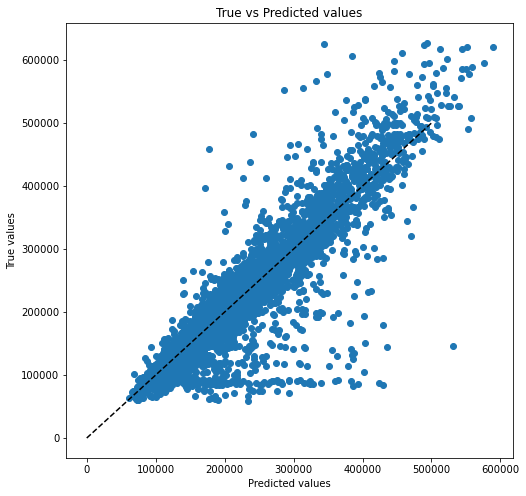

In [1171]:
evaluate_preds(y_train, y_train_preds)

R2:	0.752
RMSE:	47801.073
MSE:	2284942582.047


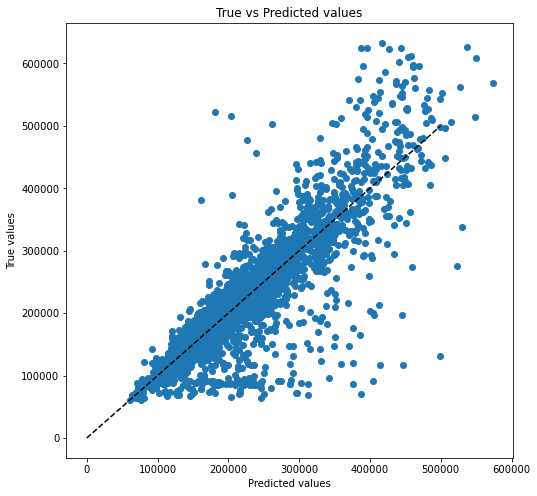

In [1172]:
evaluate_preds(y_valid, y_valid_preds)

In [1173]:
test_result = model.predict(test_df)

In [1174]:
submit = pd.read_csv('./sample_submission.csv')
submit['Price'] = test_result
submit.head()

,Id,Price
0,4567,164719.375509
1,5925,122822.579796
2,960,145812.304488
3,3848,126980.650812
4,746,174090.245631


In [1175]:
submit.to_csv('rf_submit.csv', index=False)

In [1176]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances



,feature_name,importance
2,Square,0.246402
1,Rooms,0.139193
12,Social_2,0.098269
3,LifeSquare,0.083897
11,Social_1,0.083725
13,Social_3,0.069837
0,DistrictId,0.064973
4,KitchenSquare,0.055226
8,Ecology_1,0.044286
7,HouseYear,0.028944
